In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.datasets
import sklearn.linear_model
from tensorflow.python.client import device_lib
from keras.layers import Dense, Activation
from keras.models import Sequential


C:\Users\rlagr\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


# Getting a little more complicated...

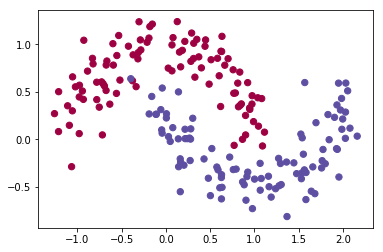

In [2]:
# Make a test dataset
np.random.seed(0)
X, y = sk.datasets.make_moons(200, noise=0.15)
y = y.reshape(-1,1)
plt.scatter(X[:,0], X[:,1], s=40, c=y.flatten(), cmap=plt.cm.Spectral)

# Numpy Net

In [15]:
# Define Activation, loss, and derivatives
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def bce(y, y_hat):
    mval = .0000000001 # prevent results set to zero
    N = y.shape[0]
    loss = -1/N * np.sum((y*np.log(y_hat.clip(min=mval)) + (1 - y)*np.log(1 - y_hat.clip(min=mval))))
    
    return loss


def d_bce(y,y_hat):
    return (y_hat - y)

def d_tanh(x):
    return (1 - np.power(x,2))



In [24]:
# Define network functionality

# Random initial Parameters
def init_param(net_in_dim, n_hidden, net_out_dim):
    
    # Layer 1 initial weights
    # Weights in matrix
    # num rows = number of x inputs (cols in data)
    # num cols = number of neurons in hidden layer stack
    W1 = 2 * np.random.randn(net_in_dim, n_hidden) - 1
    
    # Layer 1 bias
    # vector, num elements = num of neurons in layer
    b1 = np.zeros((1, n_hidden))
    
    # Second Layer weights
    # Matrix
    # num rows = input from prev layer (num neurons in stack)
    # num cols = desired num final outs
    W2 =  2 * np.random.randn(n_hidden, net_out_dim) - 1
    
    # Second Layer Bias
    # vector, num ele = num outputs
    b2 = np.zeros((1, net_out_dim))
    
    # Return params for use
    mod = {'W1' : W1, 'W2' : W2,
           'b1' : b1, 'b2' : b2}
    return mod

# Forward Prop
def f_pass(mod, x):
    
    # Current thetas
    W1, W2 = mod['W1'], mod['W2']
    # Current Biases
    b1, b2 = mod['b1'], mod['b2']
    
    #Linear 1 and Activation 1
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    
    #Linear 2 and Activation 2
    z2 = a1.dot(W2) + b2
    a2 = sigmoid(z2)
    
    #return pass results
    res = {'x': x, 'z1' : z1, 'a1' : a1, 'z2' : z2, 'a2':a2} 
    return res

# Back Prop
# Calculate Gradients
def b_pass(mod,res,y):
    
    # Load params
    W1, W2 = mod['W1'], mod['W2']
    b1, b2 = mod['b1'], mod['b2']
    
    # Load Results
    x, a1, a2 = res['x'], res['a1'], res['a2']
    
    # Chain Rule
    # Loss to output
    dz2 = d_bce(y,a2)
    # loss to second thetas
    dW2 = np.dot(a1.T,dz2)
    # Second Bias
    db2 = np.sum(dz2, axis=0, keepdims=True)
    
    # Loss to first layer out
    dz1 = dz2.dot(W2.T) * d_tanh(a1)
    # Loss to first layer theta
    dW1 = np.dot(x.T, dz1)
    # Loss to layer 1 bias
    db1 = np.sum(dz1, axis=0)
    
    # Save gradients for update
    gradient = {'dW2' : dW2, 'db2': db2,
                'dW1' : dW1, 'db1' : db1}
    
    return gradient

# Update Parameters
def update_param(mod,grad,alpha):
    
    # Current Parameters
    W1, W2 = mod['W1'], mod['W2']
    b1, b2 = mod['b1'], mod['b2']
    
    # Update with gradients
    W1 -= alpha * grad['dW1']
    W2 -= alpha * grad['dW2']
    b1 -= alpha * grad['db1']
    b2 -= alpha * grad['db2']
    
    mod = {'W1' : W1, 'W2' : W2,
           'b1' : b1, 'b2' : b2}
    
    return mod

In [3]:
# Define Helper Functions

# Binary Predictions
def pred(mod, x):
    
    # Calculate probs
    p = f_pass(mod, x)
    
    # Retrive prediction
    # Output of Activation 2
    y_hat = p['a2']
    
    # Convert to binary
    y_hat = np.where(y_hat >= 0.5, 1, 0)
    
    return y_hat

# Calculate Accuracy
def accuracy(mod, x, y):
    n = y.shape[0]
    preds = pred(mod, x)
    # same shape
    preds = preds.reshape(y.shape)
    
    # find wrong
    w = np.sum(np.abs(preds-y))
    acc = ((n - w)/n) * 100
    
    return acc

def plot_dbound(pred_fn):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_fn(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=plt.cm.Spectral)

In [20]:
# Function to run the Whole thing

def train(mod, X_, y_, alpha, npass=25000, verb=None):
    
    # run iterations
    for i in range(npass):
        #Forward
        res = f_pass(mod, X_)
        # Back
        grad = b_pass(mod, res, y)
        # update
        mod = update_param(mod=mod,grad=grad,alpha=alpha)
        
        # Print update
        if verb is not None and i % verb == 0:
            y_hat = res['a2']
            loss = bce(y,y_hat)
            acc = accuracy(mod, X_, y_)
            print('-----Iteration {} ------'.format(i))
            print('\tLoss: {:.4f} -  Accuracy: {:.2f}'.format(loss,acc))
        
    return mod

### Running Numpy Net

In [38]:
# Hyperparams
hidden = 5
alpha = 0.01

np.random.seed(0)

#def init_param(net_in_dim, n_hidden, net_out_dim
# Initialize params
mod = init_param(2, hidden, 1)

# Train Model
mod = train(mod, X, y, alpha=alpha, npass=5000, verb=500)

-----Iteration 0 ------
	Loss: 1.6749 -  Accuracy: 76.00
-----Iteration 500 ------
	Loss: 0.0243 -  Accuracy: 99.50
-----Iteration 1000 ------
	Loss: 0.0193 -  Accuracy: 99.50
-----Iteration 1500 ------
	Loss: 0.0172 -  Accuracy: 99.50
-----Iteration 2000 ------
	Loss: 0.0160 -  Accuracy: 99.50
-----Iteration 2500 ------
	Loss: 0.0151 -  Accuracy: 99.50
-----Iteration 3000 ------
	Loss: 0.0145 -  Accuracy: 99.50
-----Iteration 3500 ------
	Loss: 0.0141 -  Accuracy: 99.50
-----Iteration 4000 ------
	Loss: 0.0137 -  Accuracy: 99.50
-----Iteration 4500 ------
	Loss: 0.0135 -  Accuracy: 99.50


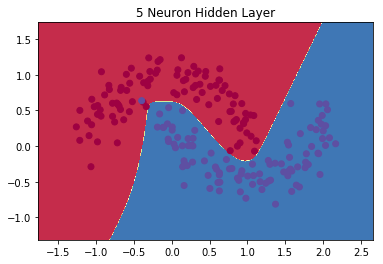

In [39]:
plt.title("5 Neuron Hidden Layer")
plot_dbound(lambda x: pred(mod,x))


# In Keras

In [10]:
# Init model

model = Sequential()

model.add(Dense(5,input_dim=2))
model.add(Activation('tanh'))

model.add(Dense(3))
model.add(Activation('sigmoid'))


model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5)                 15        
_________________________________________________________________
activation_5 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 18        
_________________________________________________________________
activation_6 (Activation)    (None, 3)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 4         
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['acc'])

In [12]:
# Train Model

hist = model.fit(X,y,epochs=900)

Instructions for updating:
Use tf.cast instead.
Epoch 1/900
200/200 [==============================] - 4s 22ms/step - loss: 0.7836 - acc: 0.5000
Epoch 2/900
200/200 [==============================] - 0s 153us/step - loss: 0.7810 - acc: 0.5000
Epoch 3/900
200/200 [==============================] - 0s 172us/step - loss: 0.7784 - acc: 0.5000
Epoch 4/900
200/200 [==============================] - 0s 177us/step - loss: 0.7759 - acc: 0.5000
Epoch 5/900
200/200 [==============================] - 0s 159us/step - loss: 0.7733 - acc: 0.5000
Epoch 6/900
200/200 [==============================] - 0s 160us/step - loss: 0.7707 - acc: 0.5000
Epoch 7/900
200/200 [==============================] - 0s 160us/step - loss: 0.7687 - acc: 0.5000
Epoch 8/900
200/200 [==============================] - 0s 162us/step - loss: 0.7664 - acc: 0.5000
Epoch 9/900
200/200 [==============================] - 0s 225us/step - loss: 0.7639 - acc: 0.5000
Epoch 10/900
200/200 [==============================] - 0s 217us/step -